# Credit Risk Modeling Using Python
## Based on online course from 365DataScience

In [1]:
#import relevant libraries

import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 

In [2]:
#import the datasets

#first dataset contains the backup storage for the data, this will not be changed throughout the project, but only kept as backup in case of errors
loan_data1 = pd.read_csv("data/3.1 loan_data_2007_2014 - 1.csv")



In [3]:
loan_data2 = pd.read_csv("data/3.1 loan_data_2007_2014 - 2.csv")


C:\Users\user\AppData\Local\Temp\ipykernel_24440\2830868825.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data2 = pd.read_csv("data/3.1 loan_data_2007_2014 - 2.csv")


In [4]:
loan_data3 = pd.read_csv("data/3.1 loan_data_2007_2014 - 3.csv",encoding = 'unicode_escape')

C:\Users\user\AppData\Local\Temp\ipykernel_24440\3320454629.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data3 = pd.read_csv("data/3.1 loan_data_2007_2014 - 3.csv",encoding = 'unicode_escape')


In [5]:
# concatenate these three files to one 
loan_data = pd.concat([loan_data1, loan_data2, loan_data3])
pd.options.display.max_rows = 50
pd.options.display.max_columns = None

In [6]:
loan_data
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466281 entries, 0 to 173353
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466281 non-null  int64  
 1   id                           466281 non-null  int64  
 2   member_id                    466281 non-null  int64  
 3   loan_amnt                    466281 non-null  int64  
 4   funded_amnt                  466281 non-null  int64  
 5   funded_amnt_inv              466281 non-null  float64
 6   term                         466281 non-null  object 
 7   int_rate                     466281 non-null  float64
 8   installment                  466281 non-null  float64
 9   grade                        466281 non-null  object 
 10  sub_grade                    466281 non-null  object 
 11  emp_title                    438693 non-null  object 
 12  emp_length                   445273 non-null  object 
 13 

In [7]:
# preprocessing the continuous variables

# delete the "year" or "years" from employement length variable
loan_data['emp_length'].unique()
loan_data["emp_length_int"] = loan_data["emp_length"].str.replace("\+ years", '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a', str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')

# transform the string into numeric
loan_data["emp_length_int"] = pd.to_numeric(loan_data["emp_length_int"])

# double check if the new variable is of a numeric type
type(loan_data["emp_length_int"][0])

C:\Users\user\AppData\Local\Temp\ipykernel_24440\4143095900.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  loan_data["emp_length_int"] = loan_data["emp_length"].str.replace("\+ years", '')


pandas.core.series.Series

In [8]:
# transfor the term variable into numeric using the same steps as above
loan_data["term"].unique()
loan_data["term_int"] = loan_data["term"].str.replace(" months", "")
loan_data["term_int"] = pd.to_numeric(loan_data["term_int"])
loan_data["term_int"].unique()

array([36, 60], dtype=int64)

In [9]:
#transform the string variable indicating date time
loan_data['earliest_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = "%b-%y")
loan_data['days_passed'] = pd.to_datetime('2022-12-31') - loan_data['earliest_date']
loan_data['month_passed'] = round(pd.to_numeric((pd.to_datetime('2022-12-31')-loan_data['earliest_date'])/np.timedelta64(1, 'M')))
loan_data['month_passed'].describe()

count    466252.000000
mean        300.482201
std          93.974981
min        -551.000000
25%         244.000000
50%         286.000000
75%         346.000000
max         648.000000
Name: month_passed, dtype: float64

In [10]:
# time since the credit issued can not be negative, so, let's check what is happening there
loan_data[loan_data['month_passed'] < 0]

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,term_int,earliest_date,days_passed,month_passed
1580,1580,1048395,1279722,21000,21000,20875.0,36 months,7.51,653.33,A,A3,NaN,NaN,MORTGAGE,49200.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,credit_card,Happiness is,591xx,MT,27.02,0.0,Sep-62,1.0,NaN,NaN,8.0,0.0,14491,19.7,15.0,f,0.00,0.00,23043.77000,22906.61,21000.00,2043.77,0.000000,0.0,0.0,Sep-13,10000.95,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,2062-09-01,-14489 days,-476.0
1770,1770,1042802,1272895,5500,5500,5500.0,36 months,7.51,171.11,A,A3,AstroMotive Auto Service,4 years,RENT,63000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 11/28/11 > investment qual...,other,shovelhead,902xx,CA,5.56,2.0,Sep-68,0.0,13.0,NaN,6.0,0.0,6981,20.1,15.0,f,0.00,0.00,5538.32000,5538.32,5500.00,38.32,0.000000,0.0,0.0,Feb-12,539.21,NaN,Sep-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,36,2068-09-01,-16681 days,-548.0
2799,2799,1031659,1249389,5200,5200,5200.0,60 months,8.90,107.70,A,A5,NaN,NaN,RENT,36000.0,Source Verified,Nov-11,Late (16-30 days),n,https://www.lendingclub.com/browse/loanDetail....,NaN,vacation,Wedding/Vacation,109xx,NY,8.17,0.0,Sep-64,0.0,NaN,NaN,6.0,0.0,465,2.2,25.0,f,1254.13,1254.13,5177.93000,5177.93,3945.87,1202.09,29.962286,0.0,0.0,Dec-15,107.70,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,2064-09-01,-15220 days,-500.0
3282,3282,1021976,1250746,5000,5000,5000.0,36 months,12.69,167.73,B,B5,Pittsburgh Public Schools,10+ years,MORTGAGE,72000.0,Source Verified,Nov-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 11/11/11 > Family Vacation...,vacation,Family getaway,151xx,PA,7.75,0.0,Sep-67,1.0,49.0,NaN,5.0,0.0,4477,32.2,25.0,f,0.00,0.00,6034.82655,6034.83,5000.00,1034.83,0.000000,0.0,0.0,Dec-14,187.76,NaN,May-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,36,2067-09-01,-16315 days,-536.0
3359,3359,1013619,1240971,21000,21000,21000.0,36 months,12.69,704.45,B,B5,MAJR Financial,10+ years,MORTGAGE,267000.0,Source Verified,Nov-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 11/10/11 > Funds will be u...,small_business,Growing Business,801xx,CO,8.87,0.0,Feb-65,2.0,46.0,NaN,10.0,0.0,51942,36.8,27.0,f,0.00,0.00,25354.04165,25354.04,21000.00,4354.04,0.000000,0.0,0.0,Dec-14,725.56,NaN,Nov-14,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,36,2065-02-01,-15373 days,-505.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In the above specification, we can see that we have measurement error in years. To be precise, earliest date the credit line issued is stated with future dates, such as '2065-05-27', which is obviously not the case. Since our data is rich enough, we will not investigate the causes of this error, and drop the values with month_passed being negative. This way, we can get rid of credits issued later than the real time. 

In [11]:
#the following 
loan_data.drop(loan_data[loan_data['month_passed'] < 0].index, inplace=True)
loan_data['month_passed'].describe()
#


count    462990.000000
mean        302.522124
std          84.827797
min         134.000000
25%         244.000000
50%         286.000000
75%         346.000000
max         648.000000
Name: month_passed, dtype: float64

In [12]:
# run the same procedure for term and issue_date variables

loan_data['earliest_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = "%b-%y")
loan_data['days_passed'] = pd.to_datetime('2022-12-31') - loan_data['earliest_date']
loan_data['month_passed'] = round(pd.to_numeric((pd.to_datetime('2022-12-31')-loan_data['earliest_date'])/np.timedelta64(1, 'M')))
loan_data['month_passed'].describe()

count    462990.000000
mean        302.522124
std          84.827797
min         134.000000
25%         244.000000
50%         286.000000
75%         346.000000
max         648.000000
Name: month_passed, dtype: float64

In [13]:
type(loan_data['term'])
loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace(' months', ''))
term_dummies = pd.get_dummies(loan_data['term_int'], prefix='term')
loan_data = pd.concat([loan_data, term_dummies], axis=1)



Since the term variable has only two inputs (36 and 60) representing months, we can confidently consider this as categorical variables. get_dummies command is creating two dummy variables. term_36 is equal to 1, when term is equal to 36 month, and 0 otherwise. The same definition is valid for term_60 variable as well. 

In [14]:
# calculate the issue date from end of 2022

loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')
loan_data['months_issue_d'] = round(pd.to_numeric((pd.to_datetime('2022-12-31') - loan_data['issue_d_date']) / np.timedelta64(1, 'M')))
loan_data['months_issue_d'].describe()

# the minimum of the months issued seems quite reasonable, therefore, we do not need to further make changes in this variable


count    463019.000000
mean        112.258810
std          14.342759
min          97.000000
25%         102.000000
50%         108.000000
75%         118.000000
max         187.000000
Name: months_issue_d, dtype: float64

## Preprocessing some discrete variables 

In [15]:
# create dummy variables for gender of the clients
all_dummies = [ pd.get_dummies(loan_data['grade'], prefix = 'grade'),
                pd.get_dummies(loan_data['sub_grade'], prefix = 'sub_grade'),
                pd.get_dummies(loan_data['home_ownership'], prefix= 'home_ownership'),
                pd.get_dummies(loan_data['verification_status'], prefix = 'verif_status'),
                pd.get_dummies(loan_data['loan_status'], prefix = 'loan_status'),
                pd.get_dummies(loan_data['purpose'], prefix = 'purpose'),
                pd.get_dummies(loan_data['addr_state'], prefix = 'addr_state'),
                pd.get_dummies(loan_data['initial_list_status'], prefix = 'initial_list_status')]
all_dummies = pd.concat(all_dummies, axis=1)

# concatenate the new dummy variables to the main dataset
loan_data = pd.concat([loan_data, all_dummies], axis=1)



This step creates dummy variables for mentioned categorical variables, such as gender, loan or verification status, or home ownership. In further modeling, these variables are treated separately. In other words, type of the ownership the client has in terms of housing could be rent, mortgage or his/her own, and these dummy variables help us estimate each of these home ownership impacts on credit risk. 

# Dealing with missing values

In [16]:
pd.options.display.max_rows=None
loan_data.isnull().sum()


Unnamed: 0                                                              0
id                                                                      0
member_id                                                               0
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_title                                                           26999
emp_length                                                          20495
home_ownership                        

Dealing with missing values (MV) in credit risk modeling can have a significant impact on model accuracy and performance. Depending on the context of each variables, we can come up with a way to deal with missing values. For example, missing values in maximum revolving amount could be replaced by the loan amount itself, meaning the limit is the loan amount per se. Employment title (emp_title) has very large number of missing values, and this has been categorized among more than 17 thousand categories. Therefore, this variable is not likely to become our main variables of interest. Dropping unimportant missing variables decreases the sample size, but has no benefits after all, sp we leave it as it is.

In [17]:
# MVs revolving limit is replaced by funded amount
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)

# MVs in annual income is replaced by mean of annual income 
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)

# MVs of the rest of the variables are replaced by zero based on their nature
loan_data['months_issue_d'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)


# Model building 

We can create dummy variables to indicate whether a continuous variable falls within certain intervals, but this is not a typical approach for logistic regression. Logistic regression is designed to model the relationship between a binary response variable and one or more predictor variables, where the predictors can be continuous, categorical, or a combination of both.

In the case of a continuous predictor variable like income, it is more common to use the raw income values directly in the logistic regression model, rather than transforming them into dummy variables based on intervals. This is because the relationship between income and the response variable may be non-linear, and splitting income into discrete intervals may lead to loss of information and decrease the accuracy of the model.

That being said, in some cases, creating interval dummy variables may be useful if the relationship between the response variable and the predictor variable is not linear, and if the intervals are based on a priori knowledge or domain expertise. In these cases, the dummy variables can be included in the logistic regression model along with the raw income values to capture the non-linear relationship. However, this approach should be used with caution, as it can result in overfitting if the number of intervals is large.

Before we begin building the model, we need to specify the definition of default. We have loan status variable indicating the the loan status, whether it has fully been paid, charged off, defaulted, delaying the payment up to 120 days and so forth. 

In the following step, qualitative variable indicating if the loan status is good or bad is assigned with dummy variable. 1 represents the payment quality being good, that is, the loan is paid off in time, while 0 means all categories that represents critical situation with payments: default, charged off, payment is delayed for 31-120 days and not meeting the credit policy. This variable is further used in logistic and other regression models as dependent variable.

In [18]:
pd.options.display.max_rows=50
pd.options.display.max_columns=None
loan_data['loan_status'].value_counts()
loan_data["payment_quality"] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default', 
                                                                        'Does not meet the credit policy. Status_Charged Off',
                                                                        'Late (31-120 days)',]), 0, 1)

## Independent variables 
We can group the independent variables into two categories. Categorical (discrete) and continuous variables. We group the continuous variables into categorical variables, such as income and debt using "Weight of Evidence" method. This is  

## Training and Test data

In [19]:
from sklearn.model_selection import train_test_split
train_test_split(loan_data.drop('payment_quality', axis = 1), loan_data['payment_quality'])

[        Unnamed: 0        id  member_id  loan_amnt  funded_amnt  \
 35506       191885   1605404    1876555       3250         3250   
 77410       370337  18955610   18093211      18000        18000   
 162763      455694  10705325   12597460       7000         7000   
 107806      107806   6415767    7947856      18000        18000   
 130016      422947  12927084   14959280      12000        12000   
 ...            ...       ...        ...        ...          ...   
 2103          2103   1036826    1266503      10000        10000   
 124750      417681  13336915   15379133      10000        10000   
 55809       348736  20959426   23242276      26575        26575   
 6214        162593   3238112    3980716       6000         6000   
 65709       222088   1209120    1450628       7000         7000   
 
         funded_amnt_inv        term  int_rate  installment grade sub_grade  \
 35506            3250.0   36 months     12.12       108.14     B        B3   
 77410           18000.0

In [20]:
loan_data_train_inputs, loan_data_test_inputs, loan_data_train_targets, loan_data_test_targets = train_test_split(loan_data.drop('payment_quality',
                                                                                                                  axis = 1), 
                                                                                                                  loan_data['payment_quality'],
                                                                                                                  test_size=0.25,
                                                                                                                  random_state=42)
shapes = [  loan_data_train_inputs.shape,
            loan_data_train_targets.shape,
            loan_data_test_inputs.shape,
            loan_data_test_targets.shape]

shapes



[(347264, 210), (347264,), (115755, 210), (115755,)]

In [21]:
inputs = loan_data_train_inputs
targets = loan_data_train_targets

df=pd.concat([inputs['grade'], targets], axis = 1)

df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count()

df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis = 1 )

df = df.iloc[:,[0,1,3]]
df

,grade,payment_quality,payment_quality
0,A,55775,0.960896
1,B,101623,0.922193
2,C,93390,0.886037
3,D,57384,0.847118
4,E,26656,0.809724
5,F,9904,0.762823
6,G,2532,0.733412


# Weight of Evidence and Information Value
Weight of Evidence (WOE) and Information Value (IV) are two statistical measures used in credit scoring and predictive modeling to evaluate the power of a predictor in explaining the target variable.

Weight of Evidence (WOE) is a measure of how well a predictor separates the positive (good) cases from the negative (bad) cases. It is the logarithmic transformation of the odds ratio and is expressed as the difference between the natural logarithm of the event rate for the positive cases and the event rate for the negative cases. WOE helps in transforming the original predictor into a new predictor that is better at separating the positive and negative cases.

Information Value (IV) is a measure of the strength of association between a predictor and the target variable. It is a simple summary statistic that can be used to select the best predictors for a predictive model. IV is the sum of the weighted differences between the event rate for the positive cases and the event rate for the negative cases, where the weight is the proportion of observations in that group.

In credit scoring, WOE and IV are used to select the best predictors for the credit scorecard, to transform the predictors so that they are better at separating the good and bad cases, and to evaluate the performance of the scorecard. In predictive modeling, they are used to identify the predictors that have the strongest association with the target variable and to transform the predictors so that they are better suited for building a predictive model.

## The formula for weight of evidence (WoE) is as following:
$$
WoE = ln\left(\frac{\text{proportion of good events}}{\text{proportion of bad events}}\right)
$$




The following woe_iv_dis function 

In [22]:
def woe_iv_dis(df, varname, qualitative_var):
    """
    Calculates the Weight of Evidence (WoE) and Information Value (IV) of a categorical variable.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the target variable and the categorical variable.
    varname (str): Name of the target variable.
    qualitative_var (str): Name of the categorical variable.
    
    Returns:
    pd.DataFrame: DataFrame containing the WoE and IV values for each category of the categorical variable.
    
    The columns of the output DataFrame are:
    - the categorical variable
    - 'freq. of class': frequency of each category
    - 'mean of class': mean value of the target variable for each category
    - 'proportions': proportion of each category in the data
    - 'n_good': number of good outcomes in each category
    - 'n_bad': number of bad outcomes in each category
    - 'prop_good': proportion of good outcomes in each category
    - 'prop_bad': proportion of bad outcomes in each category
    - 'weight_of_evidence': WoE value for each category
    - 'delta_WoE': difference in absolute value of WoE between consecutive categories
    - 'info_value': IV value for the categorical variable
    """
    df = pd.concat([df[varname], qualitative_var], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis = 1 )

    df = df.iloc[:, [0,1,3]]
    df.columns = [df.columns.values[0], 'freq. of class', 'mean of class']
    df['proportions'] = df['freq. of class'] / df['freq. of class'].sum()
    df['n_good'] = df['mean of class'] * df['freq. of class']
    df['n_bad'] = (1 - df['mean of class']) * df['freq. of class']
    df['prop_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['weight_of_evidence'] = np.log(df['prop_good']/df['prop_bad'])
    df = df.sort_values(['weight_of_evidence'])
    df = df.reset_index(drop=True)
    df['delta_WoE'] = df['weight_of_evidence'].diff().abs()
    df['info_value'] = (df['prop_good'] - df['prop_bad']) * df['weight_of_evidence']
    df['info_value'] = df['info_value'].sum()
    
    return df
    

In [23]:
inputs = loan_data_train_inputs
targets = loan_data_train_targets

df_test = woe_iv_dis(df=inputs, varname='grade',  qualitative_var= targets)
df_test

,grade,freq. of class,mean of class,proportions,n_good,n_bad,prop_good,prop_bad,weight_of_evidence,delta_WoE,info_value
0,G,2532,0.733412,0.007291,1857.0,675.0,0.005997,0.017952,-1.096479,NaN,0.282527
1,F,9904,0.762823,0.028520,7555.0,2349.0,0.024397,0.062473,-0.940264,0.156215,0.282527
2,E,26656,0.809724,0.076760,21584.0,5072.0,0.069701,0.134894,-0.660267,0.279997,0.282527
3,D,57384,0.847118,0.165246,48611.0,8773.0,0.156980,0.233324,-0.396313,0.263954,0.282527
4,C,93390,0.886037,0.268931,82747.0,10643.0,0.267215,0.283059,-0.057598,0.338714,0.282527
5,B,101623,0.922193,0.292639,93716.0,7907.0,0.302638,0.210293,0.364037,0.421635,0.282527
6,A,55775,0.960896,0.160613,53594.0,2181.0,0.173071,0.058005,1.093170,0.729133,0.282527


In [24]:
def plot_woe(df_woe_iv, fig_size=(20,8), x_degree=0):
    """"""
    x = np.array(df_woe_iv.iloc[:,0].apply(str))
    y = df_woe_iv['weight_of_evidence']
    plt.figure(figsize=fig_size)
    plt.plot(x,y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_woe_iv.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence  ' + df_woe_iv.columns[0]))
    plt.xticks(rotation = x_degree)
    


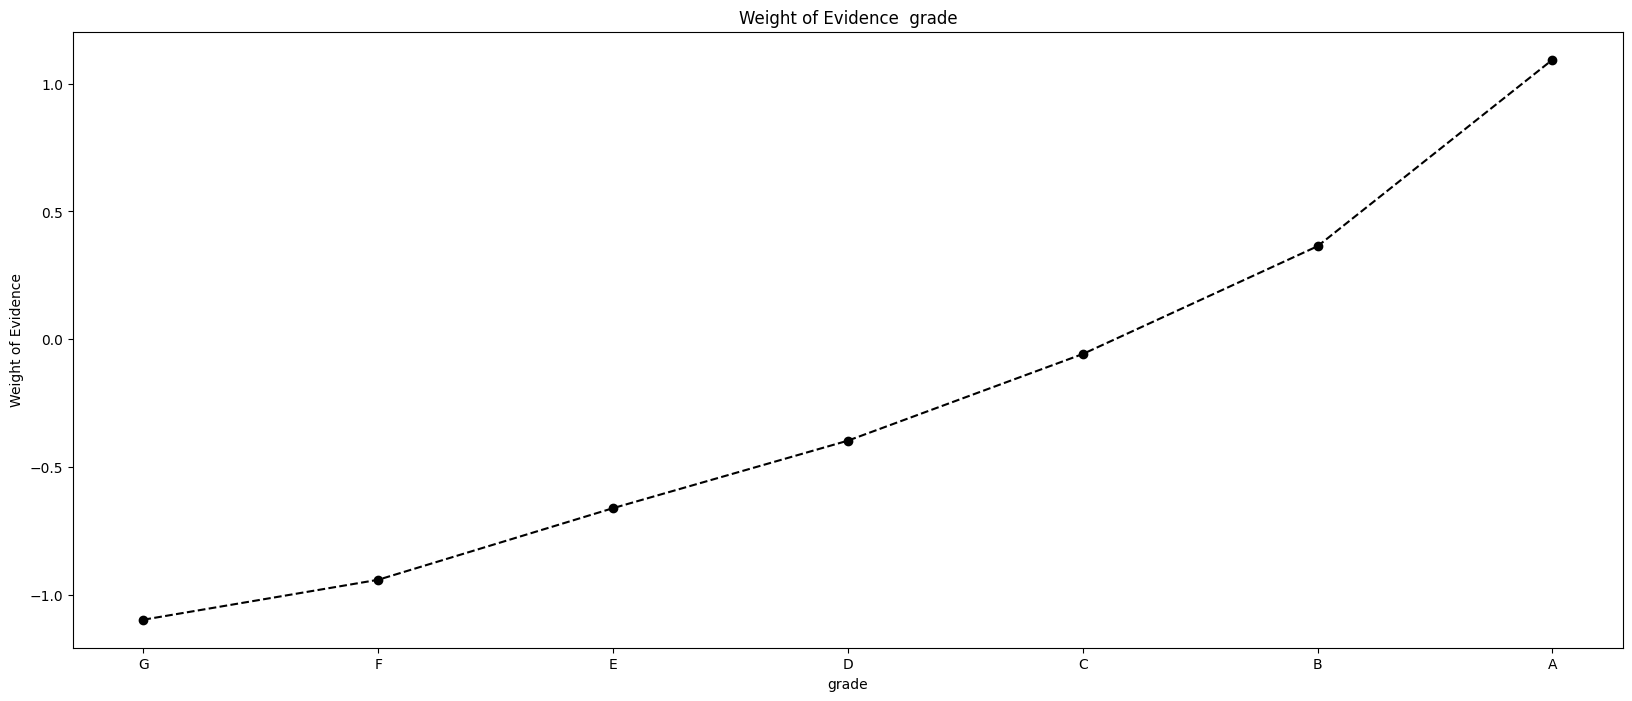

In [25]:
plot_woe(df_test)

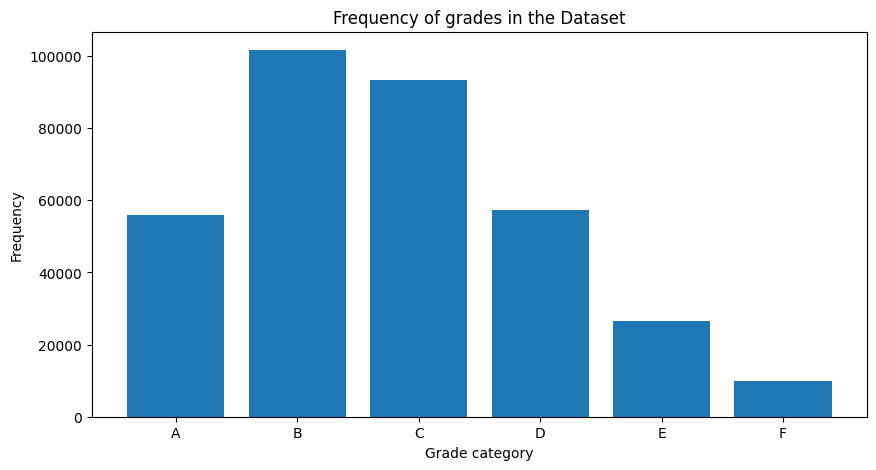

In [26]:
grades  = inputs['grade']
grades_order = ['A', 'B', 'C', 'D', 'E', 'F']
grades.sort_values()
#count the grades
grade_counts = {}
for grade in grades:
    if grade in grade_counts:
        grade_counts[grade] +=1
    else:
        grade_counts[grade] = 1

# plot the grade frequency
plt.figure(figsize=(10,5))
plt.bar(grades_order, [grade_counts[grade] for grade in grades_order])
plt.xlabel('Grade category')
plt.ylabel('Frequency')
plt.title('Frequency of grades in the Dataset')
plt.show()

In [27]:
# Estimate the weight of evidence of the home ownership variable
df_home_own = woe_iv_dis(inputs, 'home_ownership', targets)
df_home_own

,home_ownership,freq. of class,mean of class,proportions,n_good,n_bad,prop_good,prop_bad,weight_of_evidence,delta_WoE,info_value
0,OTHER,140,0.842857,0.000403,118.0,22.0,0.000381,0.000585,-0.428842,NaN,inf
1,NONE,36,0.861111,0.000104,31.0,5.0,0.000100,0.000133,-0.283934,0.144907,inf
2,RENT,140612,0.874712,0.404914,122995.0,17617.0,0.397189,0.468537,-0.165204,0.118730,inf
3,OWN,30978,0.892408,0.089206,27645.0,3333.0,0.089274,0.088644,0.007088,0.172293,inf
4,MORTGAGE,175497,0.905280,0.505371,158874.0,16623.0,0.513053,0.442101,0.148840,0.141752,inf
5,ANY,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf,inf


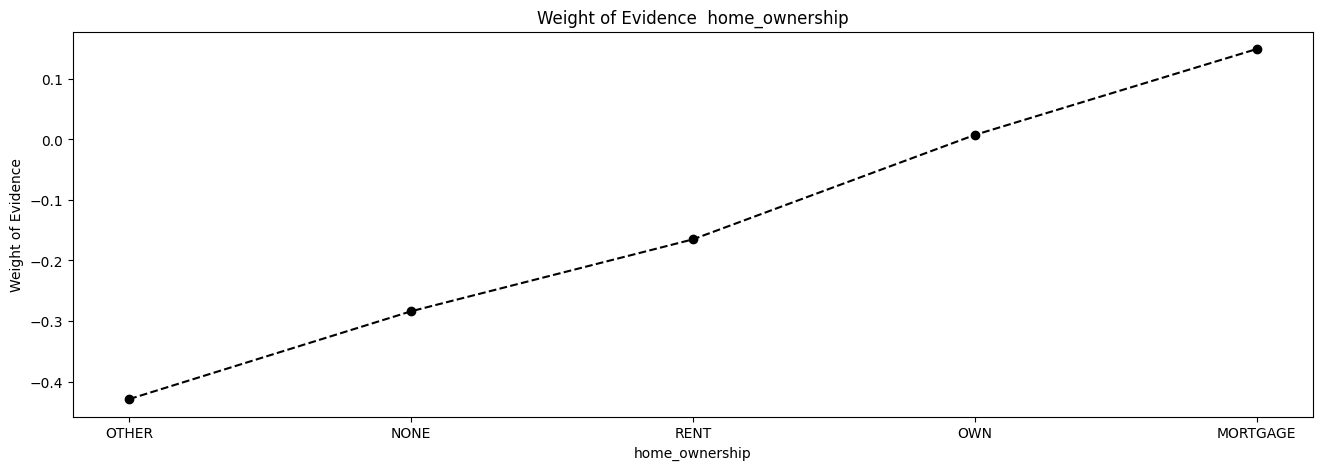

In [28]:
plot_woe(df_home_own, (16,5))

In [29]:
# home ownership categories "other", "none" and "any" can be combined
inputs['home_own_none_other_any_combined'] = sum([inputs['home_ownership_ANY'], inputs['home_ownership_NONE'], inputs['home_ownership_OTHER']])

''' this step leaves us only four categories: rent, mortgage, own, and others combined in one variable. 
Using unification technique we combine the three less informative variables into one which does not impact on final result very much, 
yet cuts computational costs'''

' this step leaves us only four categories: rent, mortgage, own, and others combined in one variable. \nUsing unification technique we combine the three less informative variables into one which does not impact on final result very much, \nyet cuts computational costs'

In [30]:
# calculate weights of evidences for location
df_location = woe_iv_dis(inputs, 'addr_state', targets)
df_location

,addr_state,freq. of class,mean of class,proportions,n_good,n_bad,prop_good,prop_bad,weight_of_evidence,delta_WoE,info_value
0,NE,10,0.700000,0.000029,7.0,3.0,0.000023,0.000080,-1.261186,NaN,inf
1,NV,4861,0.866900,0.013998,4214.0,647.0,0.013608,0.017207,-0.234662,1.026523,inf
2,HI,1832,0.868450,0.005276,1591.0,241.0,0.005138,0.006410,-0.221163,0.013500,inf
3,FL,23461,0.876391,0.067560,20561.0,2900.0,0.066398,0.077128,-0.149798,0.071364,inf
4,AL,4356,0.876722,0.012544,3819.0,537.0,0.012333,0.014282,-0.146738,0.003060,inf
5,NM,1930,0.879275,0.005558,1697.0,233.0,0.005480,0.006197,-0.122905,0.023833,inf
6,NY,29922,0.883029,0.086165,26422.0,3500.0,0.085325,0.093085,-0.087050,0.035855,inf
7,NC,9514,0.883855,0.027397,8409.0,1105.0,0.027155,0.029388,-0.079027,0.008023,inf
8,LA,4115,0.884083,0.011850,3638.0,477.0,0.011748,0.012686,-0.076811,0.002216,inf
9,MO,5532,0.886117,0.015930,4902.0,630.0,0.015830,0.016755,-0.056805,0.020006,inf


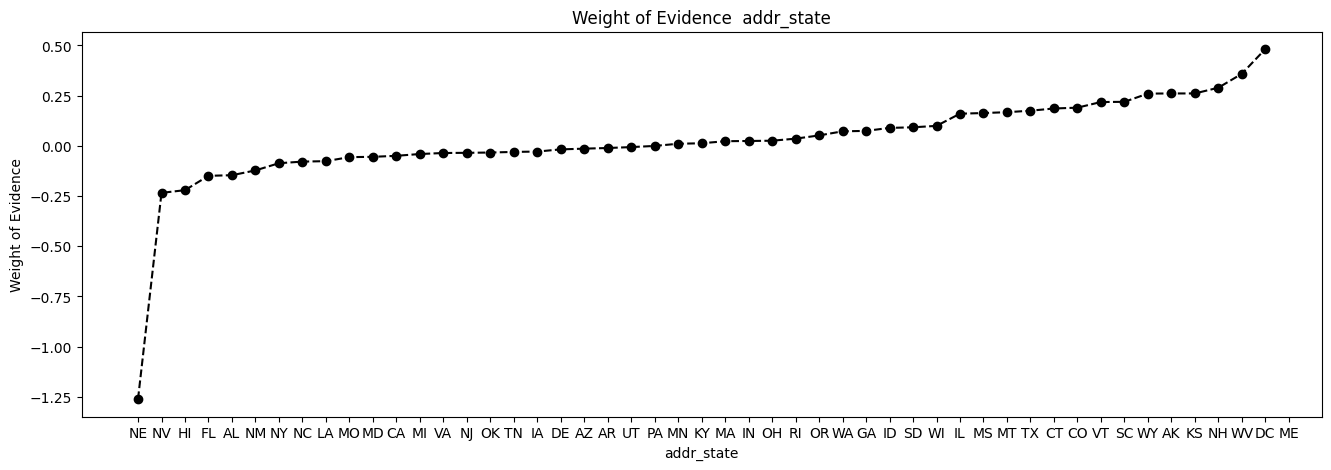

In [31]:
plot_woe(df_location, (16,5))

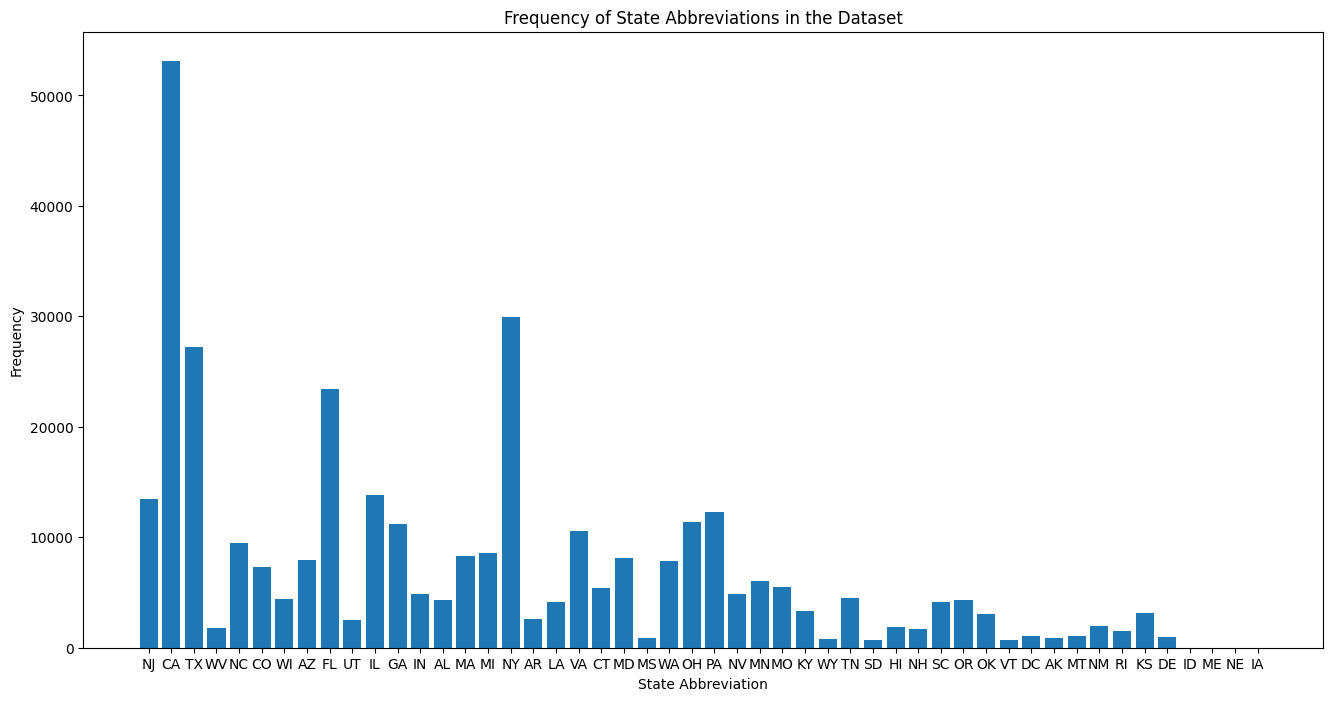

In [32]:
states = inputs['addr_state']
state_counts = {}
for state in states:
    if state in state_counts:
        state_counts[state] += 1
    else:
        state_counts[state] = 1

# Plot the frequency chart
plt.figure(figsize=(16,8))
plt.bar(state_counts.keys(), state_counts.values())
plt.xlabel('State Abbreviation')
plt.ylabel('Frequency')
plt.title('Frequency of State Abbreviations in the Dataset')
plt.show()

## Grouping the states based on states to create classes

This step of grouping the weights of evidence can be useful in credit risk modeling because it allows the model to group similar observations together. This can help to simplify the analysis and reduce the noise in the data, which can lead to more accurate predictions.

In credit risk modeling, the weights of evidence are often used to indicate the likelihood of a borrower defaulting on a loan. By grouping similar weights of evidence together, the analyst can identify patterns and relationships that may not be immediately apparent when examining each weight of evidence individually. This can help to inform the development of more accurate and effective credit risk models.

In the next several steps carry out the process of grouping the states. States with higher frequency in the data are taken as separate groups. States like California, New York, Florida and Texas are relatively more frequent than other states, therefore, each of these states constitute one group itself. For the rest, we employ the techniques to group them together and create classes based on weights of evidences.





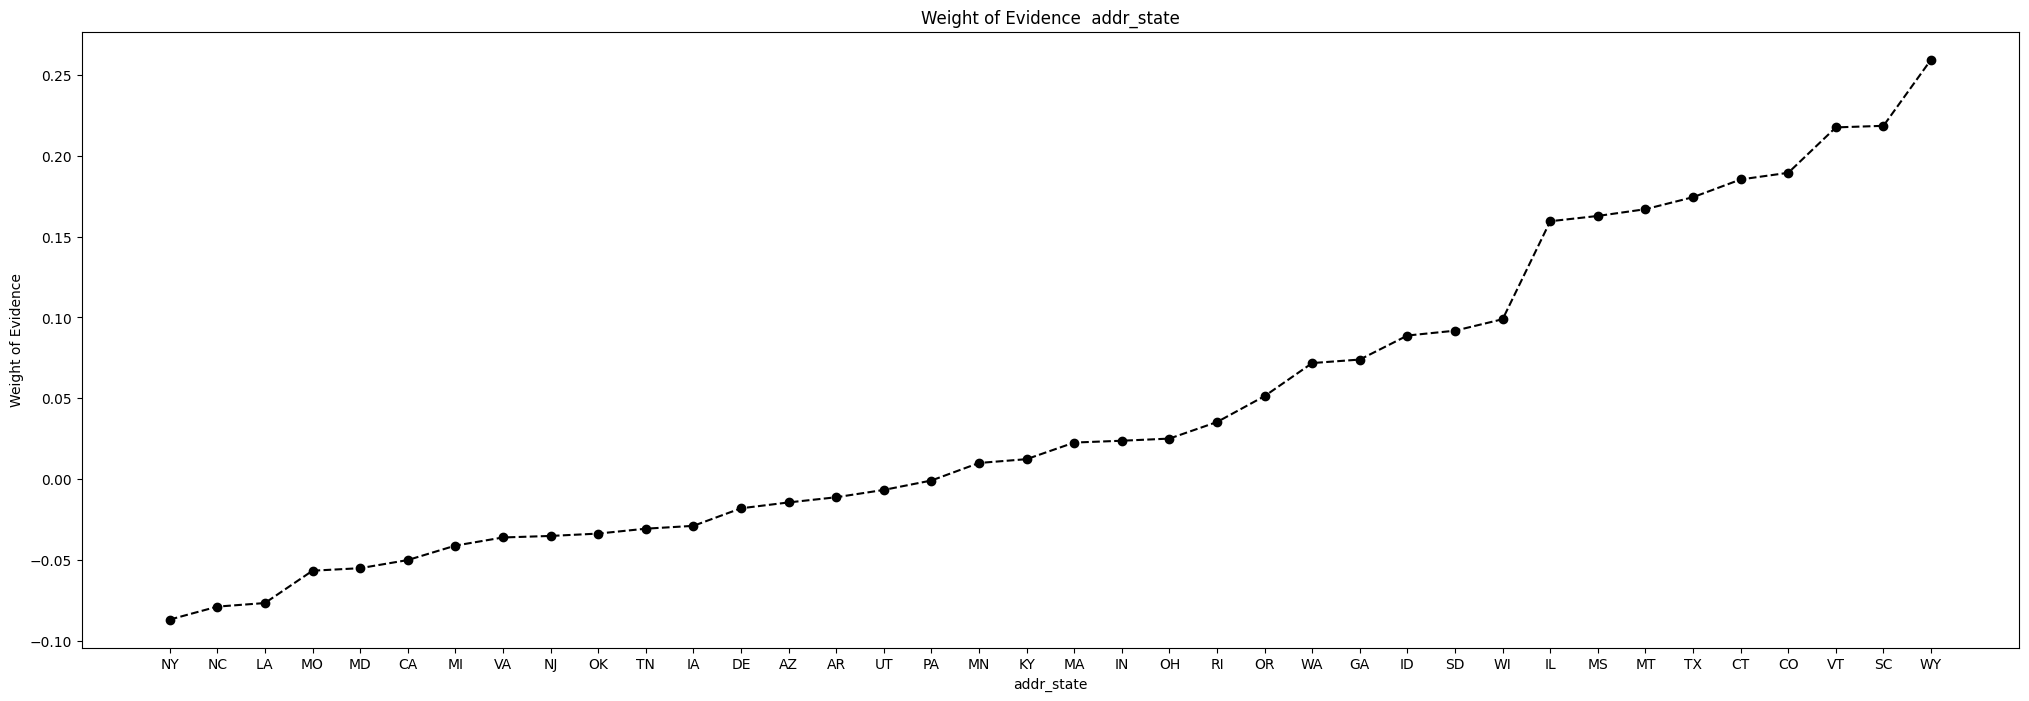

In [33]:
# plot the weights of evidence removing the outliers
plot_woe(df_location.iloc[6:-6,:], (25,8))

In [34]:
# The 4 highly frequent states
inputs["st_group_TX"] = sum(inputs['addr_state_TX'])
inputs["st_group_FL"] = sum(inputs['addr_state_FL'])
inputs["st_group_NY"] = sum(inputs['addr_state_NY'])
inputs["st_group_CA"] = sum(inputs['addr_state_CA'])


# The rest 
inputs['st_group_NM_MD_NC_LA_MD'] = sum([inputs['addr_state_NM'],inputs['addr_state_MD'],inputs['addr_state_NC'], inputs['addr_state_LA'],
                                                inputs['addr_state_MD']])

inputs['st_group_MI_NJ_VA'] = sum([inputs['addr_state_MI'],inputs['addr_state_NJ'],inputs['addr_state_VA']])

inputs['st_group_OK_TN_AZ_DE_AR_UT'] = sum([inputs['addr_state_OK'],inputs['addr_state_TN'],inputs['addr_state_AZ'], inputs['addr_state_DE'],
                                                inputs['addr_state_AR'],inputs['addr_state_UT']])

inputs['st_group_KY_MN_NA_IN_OH'] = sum([inputs['addr_state_KY'],inputs['addr_state_MN'],inputs['addr_state_MA'],inputs['addr_state_IN'],
                                        inputs['addr_state_OH']])

inputs['st_group_RI_OR_GA_WA'] = sum([inputs['addr_state_RI'],inputs['addr_state_OR'],inputs['addr_state_GA'], inputs['addr_state_WA']])

inputs['st_group_SD_ID'] = sum([inputs['addr_state_SD'],inputs['addr_state_ID']])

inputs['st_group_MS_MT'] = sum([inputs['addr_state_MS'], inputs['addr_state_MT']])

inputs['st_group_IL_CT_CO'] = sum([inputs['addr_state_IL'], inputs['addr_state_CT'], inputs['addr_state_CT'], inputs['addr_state_CO']])

inputs['st_group_VT_SC'] = sum([inputs['addr_state_VT'], inputs['addr_state_SC']])

inputs['st_group_KS'] = sum([inputs['addr_state_KS']])



inputs.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,term_int,earliest_date,days_passed,month_passed,term_36,term_60,issue_d_date,months_issue_d,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verif_status_Not Verified,verif_status_Source Verified,verif_status_Verified,loan_status_Charged Off,loan_status_Current,loan_status_Default,loan_status_Does not meet the credit policy. Status:Charged Off,loan_status_Does not meet the credit policy. Status:Fully Paid,loan_status_Fully Paid,loan_status_In Grace Period,loan_status_Late (16-30 days),loan_status_Late (31-120 days),purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,home_own_none_other_any_combined,st_group_TX,st_group_FL,st_group_NY,st_group_CA,st_group_NM_MD_NC_LA_MD,st_group_MI_NJ_VA,st_group_OK_TN_AZ_DE_AR_UT,st_group_KY_MN_NA_IN_OH,st_group_RI_OR_GA_WA,st_group_SD_ID,st_group_MS_MT,st_group_IL_CT_CO,st_group_VT_SC,st_group_KS
17570,310497,26539344,29032371,10000,10000,10000.0,36 months,16.99,356.48,D,D3,Managing Member/Owner,7 years,RENT,72000.0,Verified,Sep-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,Business,085xx,NJ,11.83,0.0,Nov-88,1.0,NaN,NaN,7.0,0.0,14807,88.7,13.0,w,6171.27,6171.27,5703.68,5703.68,3828.73,1874.95,0.0,0.0,0.0,Jan-16,356.48,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,26440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,7.0,36,1988-11-01,12478 days,410.0,1,0,2014-09-01,100.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [35]:
inputs["term:36"] = np.where((inputs['term_int']==36),1,0)
inputs["term:60"] = np.where((inputs['term_int']==60),1,0)


In [36]:
df_ver_status = woe_iv_dis(inputs, 'verification_status', targets)
df_purpose = woe_iv_dis(inputs, "purpose", targets)
df_init_status = woe_iv_dis(inputs, "initial_list_status", targets)

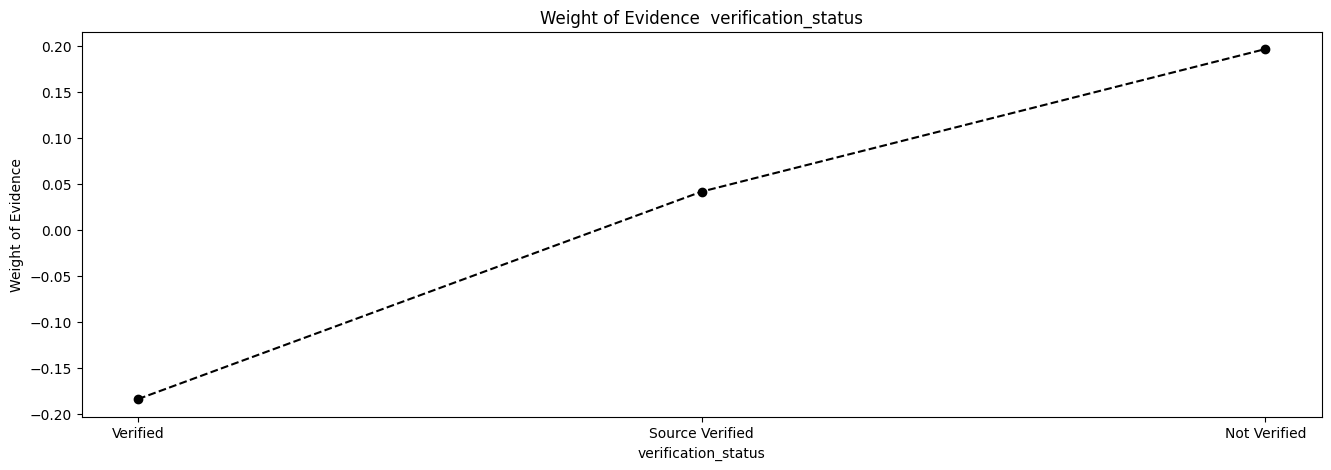

In [37]:
plot_woe(df_ver_status, (16,5))

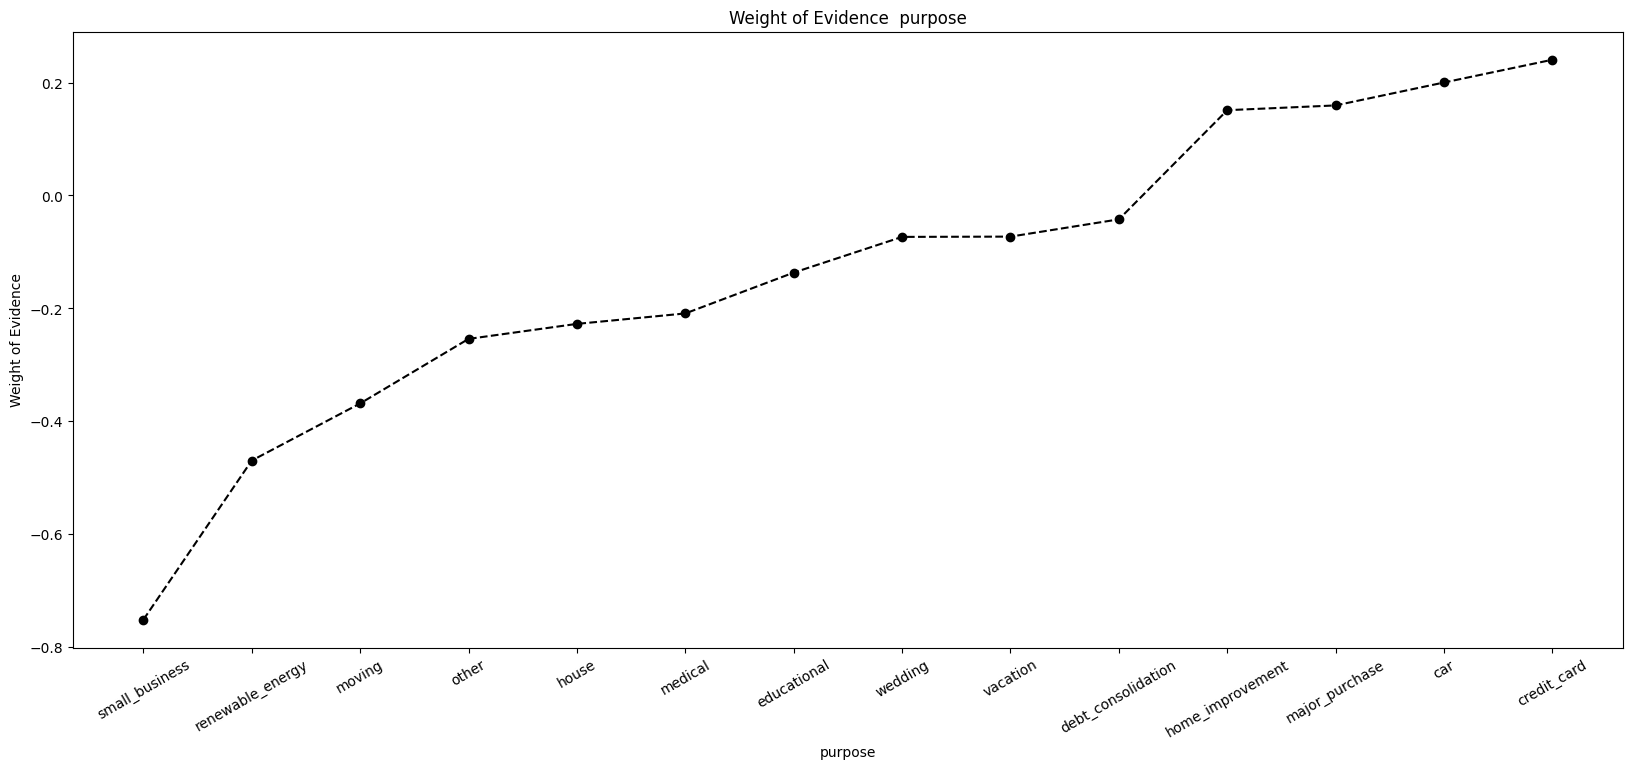

In [38]:
plot_woe(df_purpose, (20,8), x_degree=30)

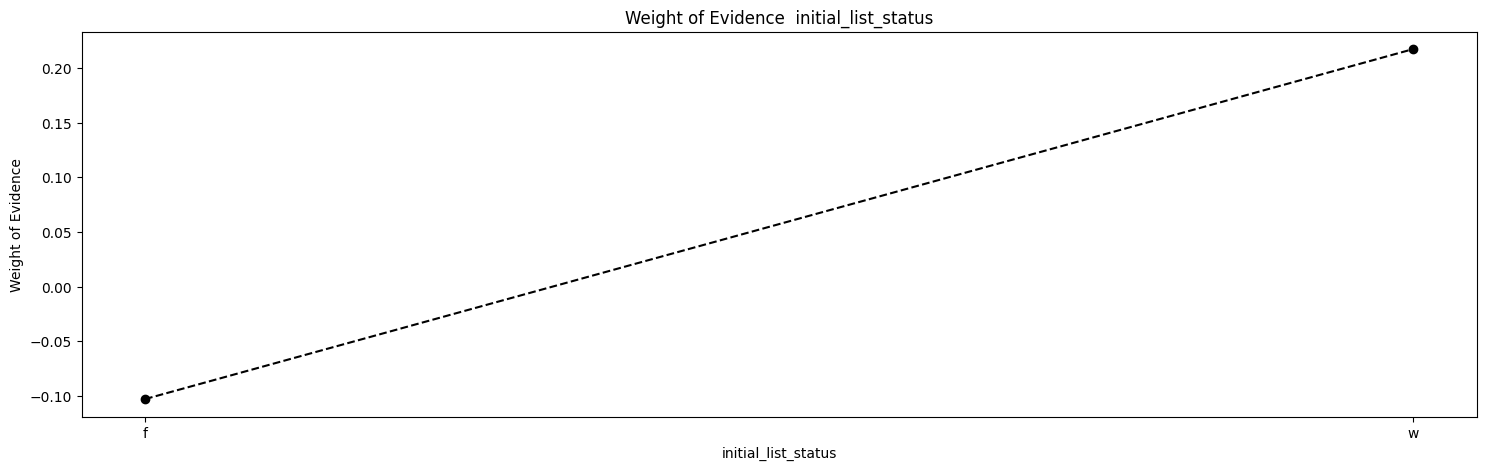

In [39]:
plot_woe(df_init_status, (18,5))

# Continuous variables

In [40]:
def woe_iv_cont(df, varname, qualitative_var):
    """
    Calculates the Weight of Evidence (WoE) and Information Value (IV) of a categorical variable.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the target variable and the categorical variable.
    varname (str): Name of the target variable.
    qualitative_var (str): Name of the categorical variable.
    
    Returns:
    pd.DataFrame: DataFrame containing the WoE and IV values for each category of the categorical variable.
    
    The columns of the output DataFrame are:
    - the categorical variable
    - 'freq. of class': frequency of each category
    - 'mean of class': mean value of the target variable for each category
    - 'proportions': proportion of each category in the data
    - 'n_good': number of good outcomes in each category
    - 'n_bad': number of bad outcomes in each category
    - 'prop_good': proportion of good outcomes in each category
    - 'prop_bad': proportion of bad outcomes in each category
    - 'weight_of_evidence': WoE value for each category
    - 'delta_WoE': difference in absolute value of WoE between consecutive categories
    - 'info_value': IV value for the categorical variable
    """
    df = pd.concat([df[varname], qualitative_var], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis = 1 )

    df = df.iloc[:, [0,1,3]]
    df.columns = [df.columns.values[0], 'freq. of class', 'mean of class']
    df['proportions'] = df['freq. of class'] / df['freq. of class'].sum()
    df['n_good'] = df['mean of class'] * df['freq. of class']
    df['n_bad'] = (1 - df['mean of class']) * df['freq. of class']
    df['prop_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['weight_of_evidence'] = np.log(df['prop_good']/df['prop_bad'])
    
    # Unlike previous weight of evidence function, we do not sort the variable by weo, but instead, keep the variable's natural order

    df['delta_WoE'] = df['weight_of_evidence'].diff().abs()
    df['info_value'] = (df['prop_good'] - df['prop_bad']) * df['weight_of_evidence']
    df['info_value'] = df['info_value'].sum()
    
    return df
    

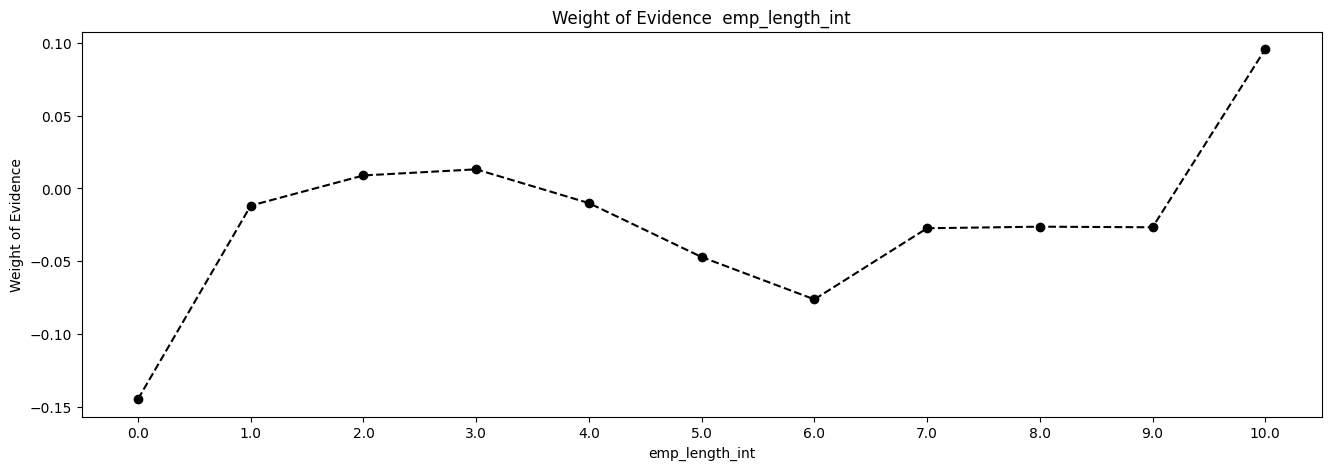

In [41]:
# employement length

df_emp_l = woe_iv_cont(inputs, 'emp_length_int', targets)
plot_woe(df_emp_l, (16,5))

In [57]:
df_emp_l

,emp_length_int,freq. of class,mean of class,proportions,n_good,n_bad,prop_good,prop_bad,weight_of_evidence,delta_WoE,info_value
0,0.0,42358,0.876930,0.121976,37145.0,5213.0,0.119953,0.138644,-0.144810,NaN,0.006176
1,1.0,21905,0.890573,0.063079,19508.0,2397.0,0.062997,0.063750,-0.011877,0.132933,0.006176
2,2.0,30878,0.892577,0.088918,27561.0,3317.0,0.089003,0.088218,0.008857,0.020734,0.006176
3,3.0,27219,0.892979,0.078381,24306.0,2913.0,0.078492,0.077473,0.013056,0.004199,0.006176
4,4.0,20941,0.890741,0.060303,18653.0,2288.0,0.060236,0.060851,-0.010155,0.023211,0.006176
5,5.0,23008,0.887083,0.066255,20410.0,2598.0,0.065910,0.069096,-0.047201,0.037046,0.006176
6,6.0,19445,0.884135,0.055995,17192.0,2253.0,0.055518,0.059920,-0.076302,0.029102,0.006176
7,7.0,19468,0.889049,0.056061,17308.0,2160.0,0.055893,0.057447,-0.027423,0.048879,0.006176
8,8.0,16735,0.889154,0.048191,14880.0,1855.0,0.048052,0.049335,-0.026350,0.001073,0.006176
9,9.0,13320,0.889114,0.038357,11843.0,1477.0,0.038245,0.039282,-0.026760,0.000409,0.006176


In [42]:
inputs['emp_length:0'] = np.where(inputs['emp_length'].isin([0]), 1, 0)
inputs['emp_length:1'] = np.where(inputs['emp_length'].isin([1]), 1, 0)
inputs['emp_length:2-4'] = np.where(inputs['emp_length'].isin(range(2,5)), 1, 0)
inputs['emp_length:5-6'] = np.where(inputs['emp_length'].isin(range(5,7)), 1, 0)
inputs['emp_length:7-9'] = np.where(inputs['emp_length'].isin(range(7,10)), 1, 0)
inputs['emp_length:10'] = np.where(inputs['emp_length'].isin([10]), 1, 0)

In [72]:
# since months_issued variable has a lot of classes, we have to decrease this number to make it easier to include in the model
inputs['months_factor'] = pd.cut(inputs['months_issue_d'], 10) 
inputs['months_factor']

17570     (96.91, 106.0]
209       (96.91, 106.0]
59241     (96.91, 106.0]
112210    (106.0, 115.0]
123812    (106.0, 115.0]
               ...      
104748    (96.91, 106.0]
75512     (96.91, 106.0]
132894    (106.0, 115.0]
147927    (115.0, 124.0]
122832    (106.0, 115.0]
Name: months_factor, Length: 347264, dtype: category
Categories (10, interval[float64, right]): [(96.91, 106.0] < (106.0, 115.0] < (115.0, 124.0] < (124.0, 133.0] ... (151.0, 160.0] < (160.0, 169.0] < (169.0, 178.0] < (178.0, 187.0]]

In [73]:
df_months = woe_iv_cont(inputs, 'months_factor', targets)
df_months

,months_factor,freq. of class,mean of class,proportions,n_good,n_bad,prop_good,prop_bad,weight_of_evidence,delta_WoE,info_value
0,"(96.91, 106.0]",152378,0.919575,0.438796,140123.0,12255.0,0.452500,0.325931,0.328103,NaN,0.085038
1,"(106.0, 115.0]",91716,0.885767,0.264110,81239.0,10477.0,0.262346,0.278644,-0.060271,0.388374,0.085038
2,"(115.0, 124.0]",50103,0.857274,0.144279,42952.0,7151.0,0.138705,0.190186,-0.315653,0.255382,0.085038
3,"(124.0, 133.0]",22966,0.834103,0.066134,19156.0,3810.0,0.061861,0.101330,-0.493497,0.177844,0.085038
4,"(133.0, 142.0]",12566,0.850231,0.036186,10684.0,1882.0,0.034502,0.050053,-0.372072,0.121425,0.085038
5,"(142.0, 151.0]",8361,0.873580,0.024077,7304.0,1057.0,0.023587,0.028112,-0.175496,0.196575,0.085038
6,"(151.0, 160.0]",4845,0.892260,0.013952,4323.0,522.0,0.013960,0.013883,0.005554,0.181050,0.085038
7,"(160.0, 169.0]",2284,0.887478,0.006577,2027.0,257.0,0.006546,0.006835,-0.043248,0.048801,0.085038
8,"(169.0, 178.0]",1137,0.901495,0.003274,1025.0,112.0,0.003310,0.002979,0.105465,0.148713,0.085038
9,"(178.0, 187.0]",908,0.915198,0.002615,831.0,77.0,0.002684,0.002048,0.270341,0.164875,0.085038


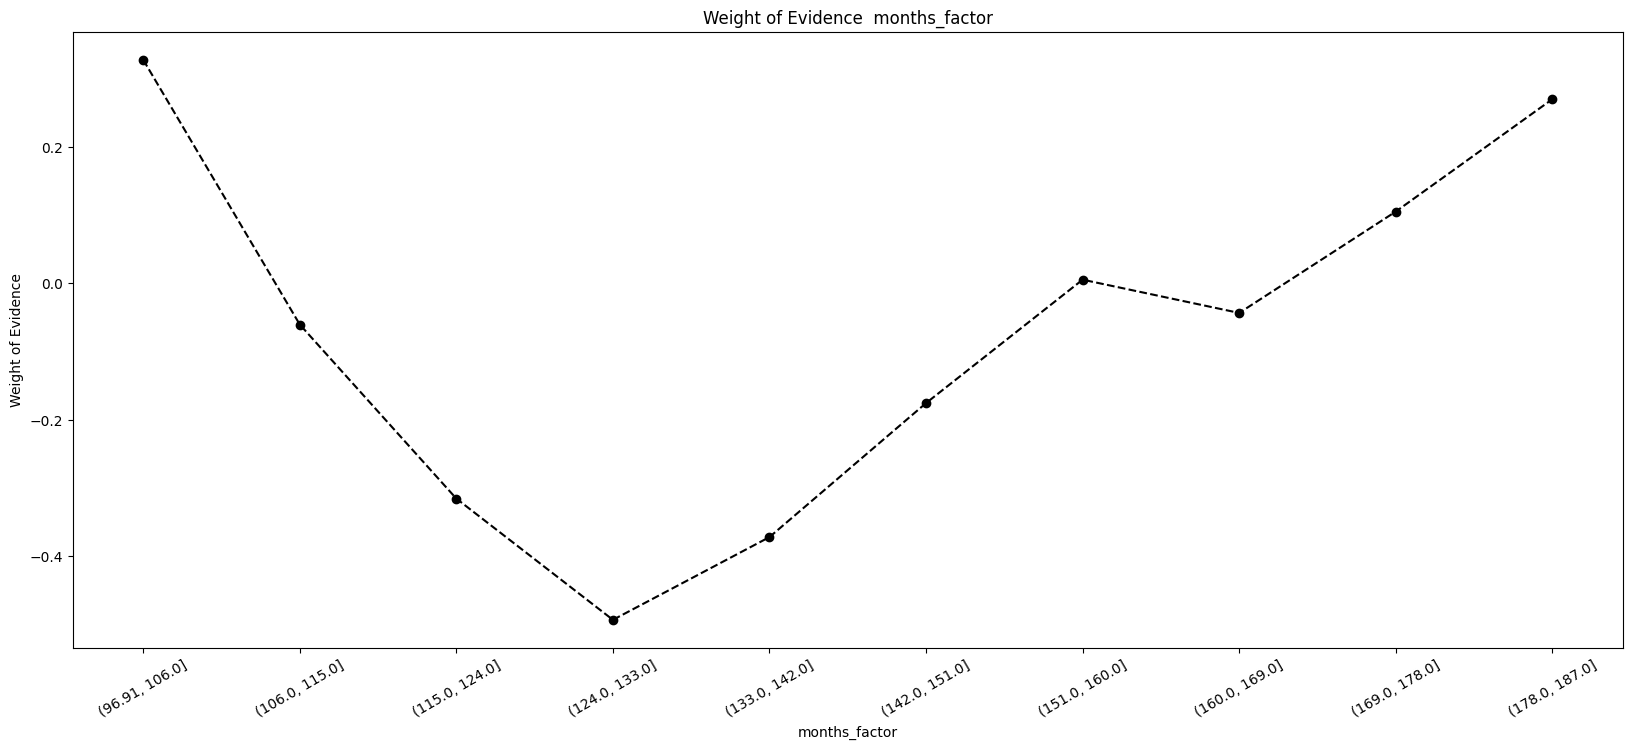

In [69]:
plot_woe(df_months, x_degree=30)

In [75]:
# using graphical representation of the number of months passed since loan issued, we can create classes for all of the trends
inputs['months_since_issued:106'] = np.where(inputs['months_factor'].isin(range(95,106)), 1,0)
inputs['months_since_issued:115'] = np.where(inputs['months_factor'].isin(range(106,115)), 1,0)
inputs['months_since_issued:124'] = np.where(inputs['months_factor'].isin(range(115,124)), 1,0)
inputs['months_since_issued:133'] = np.where(inputs['months_factor'].isin(range(124,133)), 1,0)
inputs['months_since_issued:142'] = np.where(inputs['months_factor'].isin(range(133,142)), 1,0)
inputs['months_since_issued:151'] = np.where(inputs['months_factor'].isin(range(142,151)), 1,0)
inputs['months_since_issued:160'] = np.where(inputs['months_factor'].isin(range(151,160)), 1,0)
inputs['months_since_issued:169'] = np.where(inputs['months_factor'].isin(range(160,169)), 1,0)
inputs['months_since_issued:178'] = np.where(inputs['months_factor'].isin(range(169,178)), 1,0)
inputs['months_since_issued:187'] = np.where(inputs['months_factor'].isin(range(178,187)), 1,0)

In [84]:
inputs['int_rate_classes'] = pd.cut(inputs['int_rate'], 10)


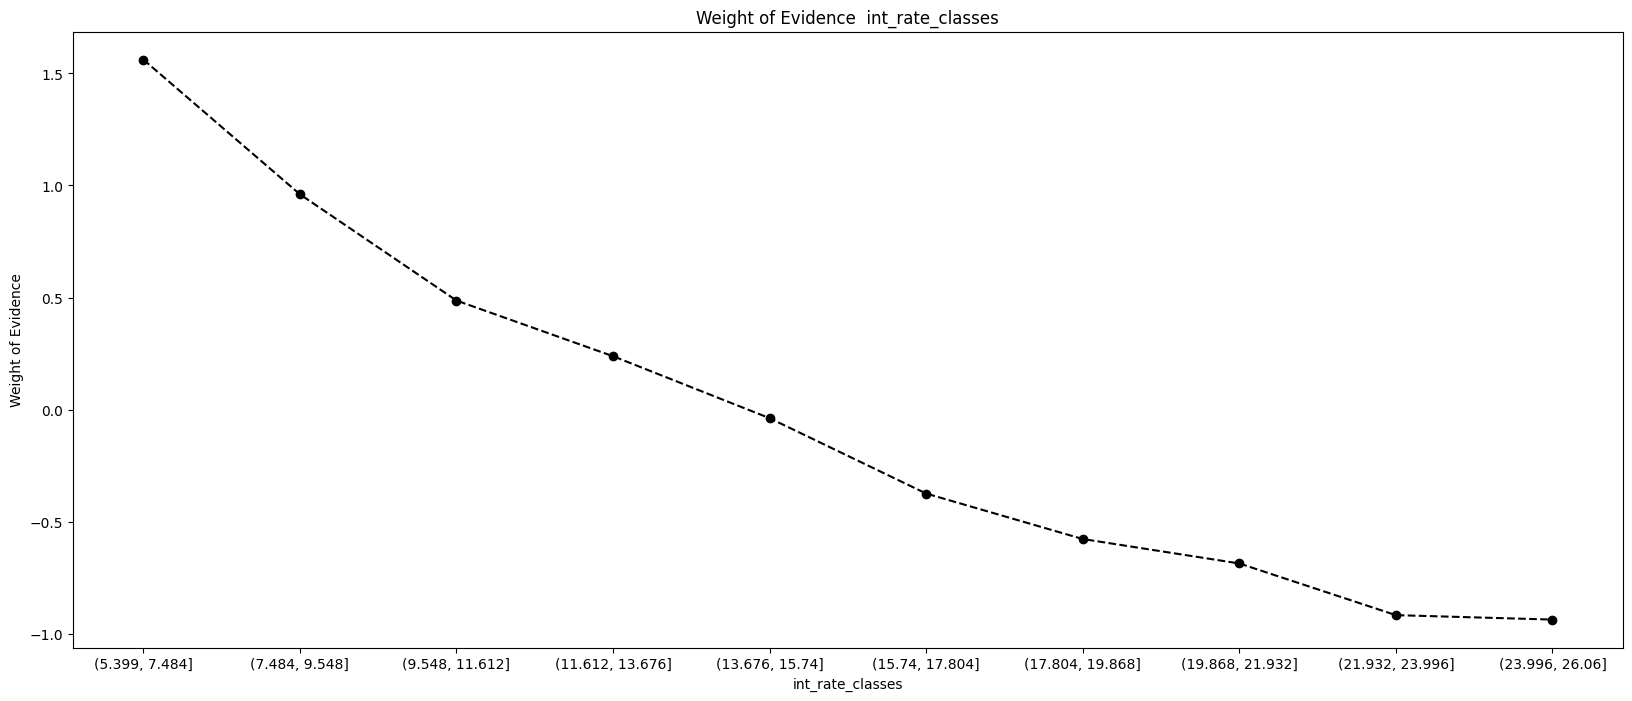

In [85]:
df_interest = woe_iv_cont(inputs, 'int_rate_classes', targets)
plot_woe(df_interest)

In [88]:
inputs['int_rate:9.5'] = np.where((inputs['int_rate_classes'].cat.codes < 9.548), 1,0)
inputs['int_rate:13.6'] = np.where((inputs['int_rate_classes'].cat.codes<=13.676) & (inputs['int_rate_classes'].cat.codes > 9.548), 1,0)
inputs['int_rate:17.8'] = np.where((inputs['int_rate_classes'].cat.codes <=17.807) & (inputs['int_rate_classes'].cat.codes > 13.676) , 1,0)
inputs['int_rate:26.06'] = np.where((inputs['int_rate_classes'].cat.codes <=26.06) & (inputs['int_rate_classes'].cat.codes > 19.86), 1,0)
